In [2]:
import zipfile
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
import numpy as np


2025-07-04 17:15:27.663370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751649327.688383    3787 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751649327.695845    3787 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_dir = "/kaggle/input/teeth-cellula/Teeth_Dataset/Training"
val_dir   = "/kaggle/input/teeth-cellula/Teeth_Dataset/Validation"
test_dir  = "/kaggle/input/teeth-cellula/Teeth_Dataset/Testing"

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


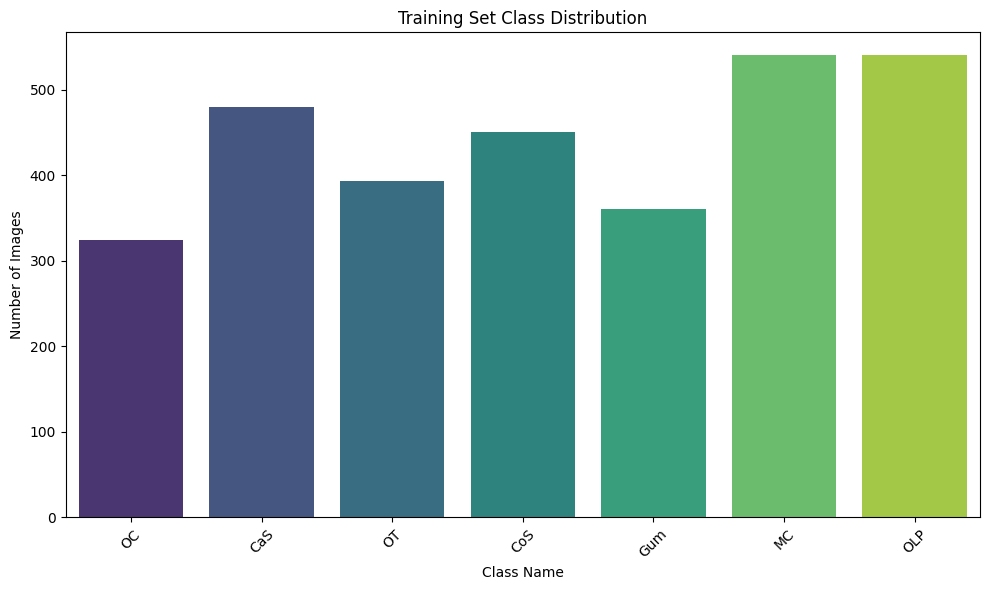

In [4]:
classes = os.listdir(train_dir)
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}
class_names = list(class_counts.keys())
class_values = list(class_counts.values())
plt.figure(figsize=(10,6))
sns.barplot(x=class_names, y=class_values, palette='viridis')
plt.title("Training Set Class Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Class Name")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

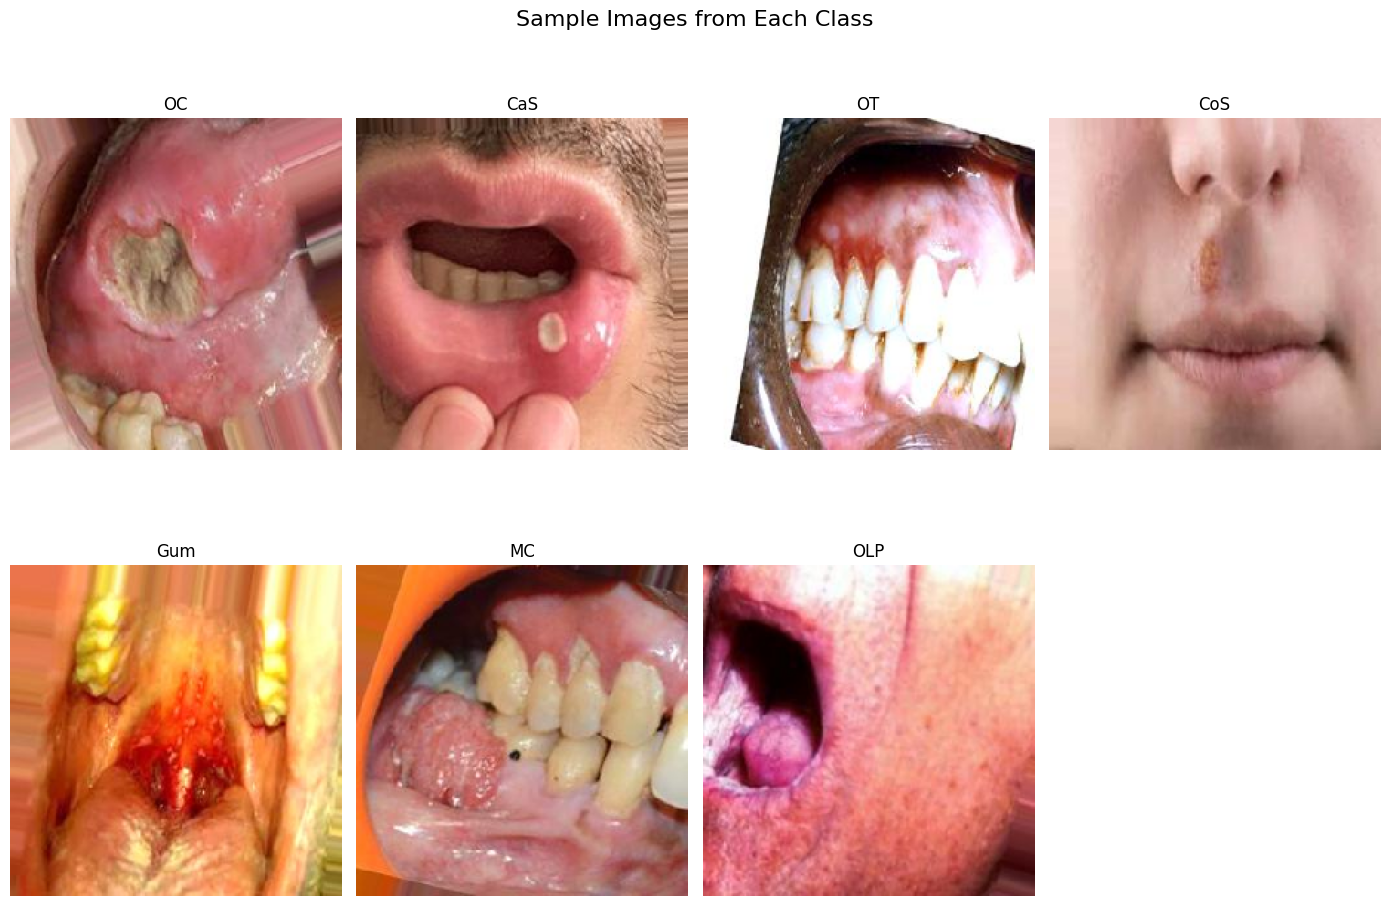

In [5]:
plt.figure(figsize=(14, 10))
for idx, class_name in enumerate(class_names[:7]):
    class_folder = os.path.join(train_dir, class_name)
    image_path = os.path.join(class_folder, random.choice(os.listdir(class_folder)))
    img = load_img(image_path, target_size=(224, 224))

    plt.subplot(2, 4, idx + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.tight_layout()
plt.show()

In [7]:
train_datagen= ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
     fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

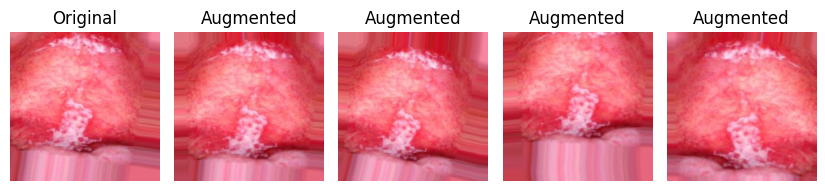

In [8]:
sample_class = class_names[2]
sample_image_path = os.path.join(train_dir, sample_class, os.listdir(os.path.join(train_dir, sample_class))[0])

# Load image and convert it to array
img = load_img(sample_image_path, target_size=(224, 224))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)  # Reshape to match input shape expected by flow()

# Plot original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 6, 1)
plt.imshow(img)
plt.title("Original")
plt.axis('off')

# Generate and plot 5 augmented images
i = 2
for batch in train_datagen.flow(x, batch_size=1):
    plt.subplot(1, 6, i)
    aug_img = array_to_img(batch[0])
    plt.imshow(aug_img)
    plt.title("Augmented")
    plt.axis('off')
    i += 1
    if i > 5:
        break

plt.tight_layout()
plt.show()

In [33]:
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle= False)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [44]:
model = tf.keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.0001),
                  input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')  ])


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,905,223 (7.27 MB)

 Trainable params: 1,904,455 (7.26 MB)

 Non-trainable params: 768 (3.00 KB)

In [46]:
early_stop= EarlyStopping(monitor='val_loss', patience=13, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5',monitor='val_accuracy',save_best_only=True,mode='max')

In [47]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 54s 459ms/step - accuracy: 0.2166 - loss: 2.7882 - val_accuracy: 0.1449 - val_loss: 9.1373
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 406ms/step - accuracy: 0.3177 - loss: 1.7378 - val_accuracy: 0.1449 - val_loss: 15.7196
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 401ms/step - accuracy: 0.3623 - loss: 1.6311 - val_accuracy: 0.1449 - val_loss: 17.9167
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 409ms/step - accuracy: 0.3939 - loss: 1.5582 - val_accuracy: 0.1449 - val_loss: 14.0889
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 406ms/step - accuracy: 0.4284 - loss: 1.4773 - val_accuracy: 0.1780 - val_loss: 7.8856
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 404ms/step - accuracy: 0.4589 - loss: 1.4367 - val_accuracy: 0.4163 - val_loss: 2.0981
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 39s 406ms/step - accuracy: 0.4669 - loss: 1.4123 - val_accuracy: 0.5272 - val_loss: 1.4142
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 40s 408ms/step - accuracy: 0.5057 - loss: 1.3223

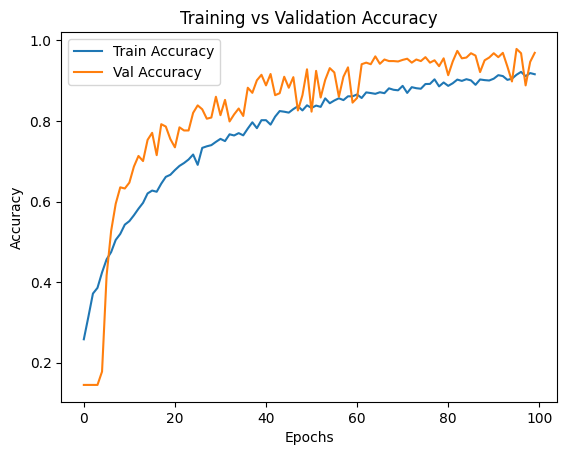

In [48]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

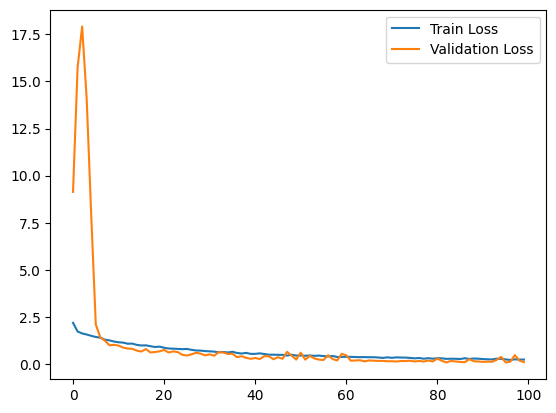

In [49]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

In [50]:
loss, acc = model.evaluate(test_generator)
print(f"Test accuracy: {acc:.2f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9617 - loss: 0.1017
Test accuracy: 0.97


In [51]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step


In [52]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         CaS       0.99      0.94      0.96       160
         CoS       0.95      1.00      0.97       149
         Gum       0.99      0.97      0.98       120
          MC       0.96      0.97      0.96       180
          OC       0.98      0.95      0.97       108
         OLP       0.95      0.97      0.96       180
          OT       0.98      0.98      0.98       131

    accuracy                           0.97      1028
   macro avg       0.97      0.97      0.97      1028
weighted avg       0.97      0.97      0.97      1028



In [53]:
print(len(true_classes), len(predicted_classes))


1028 1028


In [54]:
print("Predicted:", predicted_classes[:10])
print("True:", true_classes[:10])
print("Class labels:", class_labels)


Predicted: [0 0 0 0 0 0 0 0 0 0]
True: [0 0 0 0 0 0 0 0 0 0]
Class labels: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']


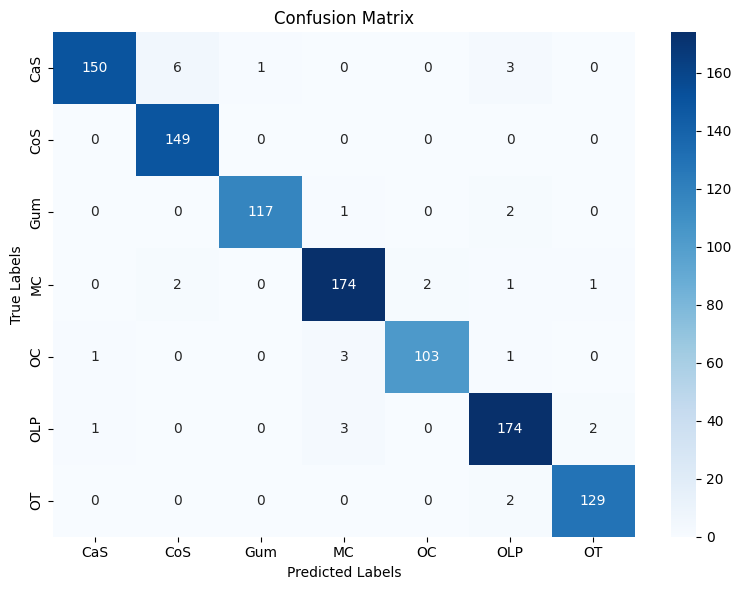

In [55]:
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


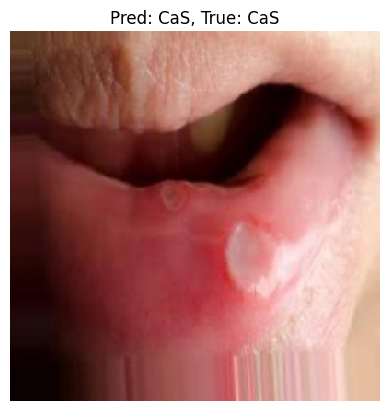

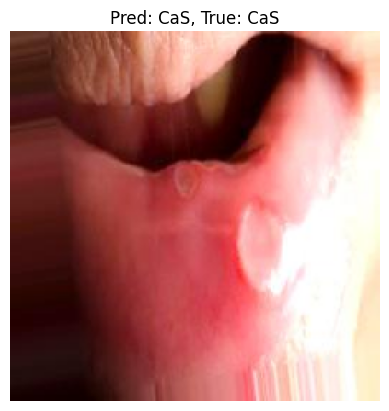

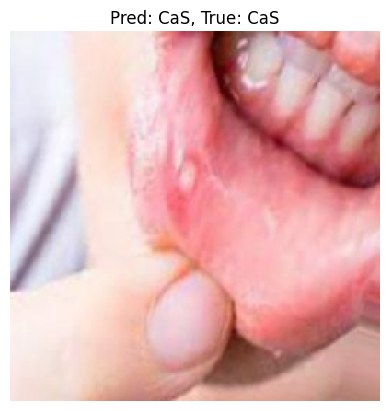

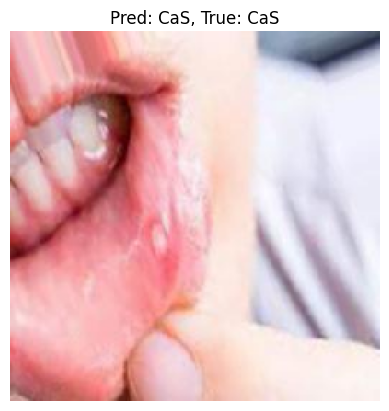

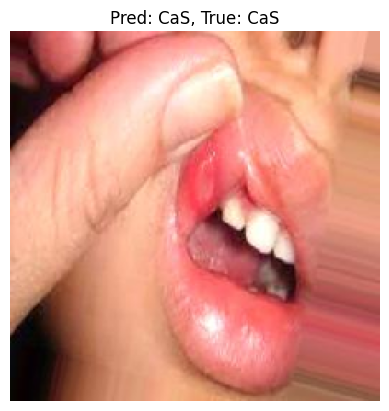

In [59]:
# Get class label mappings
class_indices = train_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}

# Get a batch of test data
test_images, test_labels = next(test_generator)

# Predict
preds = model.predict(test_images)

for i in range(5):  # Show first 5 predictions
    plt.imshow(test_images[i])
    pred_class = inv_class_indices[np.argmax(preds[i])]
    true_class = inv_class_indices[np.argmax(test_labels[i])]
    plt.title(f"Pred: {pred_class}, True: {true_class}")
    plt.axis('off')
    plt.show()


# **Related Works**
# Paper(1): Mouth and oral disease classifcation using InceptionResNetV2 method

This study presents a deep learning approach for diagnosing **seven oral diseases** using the **InceptionResNetV2** architecture and a custom-built dataset.

---

##  Objective

Develop an accurate and automated classifier for:
- Canker Sores (CaS)
- Cold Sores (CoS)
- Gingivostomatitis (Gum)
- Mouth Cancer (MC)
- Oral Cancer (OC)
- Oral Lichen Planus (OLP)
- Oral Thrush (OT)

---

##  MOD Dataset

- 517 raw oral disease images collected from clinics and online sources
- Expert annotated and categorized into 7 classes
- Augmentation expanded the dataset to ~5143 images
- Split: 60% Train, 20% Validation, 20% Test

---

##  Methodology

**Model Used:** InceptionResNetV2 with transfer learning  
**Training Setup:**
- Input Size: 224×224
- Batch Size: 4
- Epochs: 50
- Optimizer: Adam (LR=0.0001)
- Loss: Categorical Crossentropy
- Early stopping on `val_loss`
- Checkpoint on best `val_accuracy`

**Preprocessing Includes:**
- Rescaling
- Rotation, shear, zoom
- Horizontal flip
- Brightness and channel shifts

---

##  Results

**With Data Augmentation:**
- **Accuracy**: 99.51%
- **F1-scores**: >98% on all classes
- **AUC Scores**: ≥ 99% per class

**Without Augmentation:**
- Accuracy dropped to 74.07%
- Demonstrates augmentation's importance

---

##  Comparison to Previous Work

| Study | Model | Accuracy |
|-------|-------|----------|
| Park et al. | CNN | 95.00% |
| Gomes et al. | CNN | 95.09% |
| Singha et al. | ResNet50 + DenseNet201 | 92.00% |
| Jaiswal et al. | EfficientNetB0 | 93.20% |
| **Proposed** | InceptionResNetV2 | **99.51%** |

---

## Conclusion

- InceptionResNetV2 shows state-of-the-art results in oral disease classification.
- The MOD dataset addresses a critical gap in available medical datasets.
- The model is promising for real-world deployment in diagnostic systems.



# Paper(2): Use of Artificial Intelligence in the Classification of Elementary Oral Lesions from Clinical Images


## Objective

Develop a deep learning model to classify clinical oral lesion images into **six elementary lesion types**:

- Papule/Nodule  
- Macule/Spot  
- Vesicle/Bullous  
- Erosion  
- Ulcer  
- Plaque

The goal is to support early diagnosis and aid non-specialist practitioners.

---

##  Dataset

- **Total Images:** 5069 anonymized clinical oral lesion images  
- **Source:** Hospital de Clínicas de Porto Alegre and UFRGS Dentistry School (Brazil)  
- **Labeling:** Manually annotated by specialists  
- **Split:**  
  - 70% Training (3550 images)  
  - 30% Testing (1519 images)  
- **Variability:** Includes both high- and low-quality images from varied devices (SLRs, smartphones)

---

## Methodology

### Models Tested:

- VGG16  
- ResNet-50  
- Xception  
- **InceptionV3**  *(Best performance)*

All models were pretrained on ImageNet and fine-tuned for 6-class classification.

### Data Augmentation:

| Class           | Original | Augmentation Factor | Final Count |
|------------------|----------|----------------------|-------------|
| Plaque           | 1618     | 1×                   | 1618        |
| Erosion          | 159      | 10×                  | 1590        |
| Vesicle/Bullous  | 308      | 5×                   | 1540        |
| Ulcer            | 1506     | 1×                   | 1506        |
| Papule/Nodule    | 1417     | 1×                   | 1417        |
| Macule/Spot      | 61       | 30×                  | 1830        |

---

##  Training Setup

- **Input Size:** 299×299 (InceptionV3)
- **Optimizer:** Adam  
- **Learning Rate:** 1e-6  
- **Loss Function:** Categorical Crossentropy  
- **Epochs:** 50  
- **Frozen Layers:** All except the last few for fine-tuning

---

##  Results

| Class           | Accuracy | Precision | Sensitivity | Specificity | F1-Score |
|------------------|----------|-----------|-------------|-------------|----------|
| Ulcer            | 91.30%   | 74.73%    | 71.71%      | 95.19%      | 73.19%   |
| Papule/Nodule    | 92.14%   | 74.52%    | 79.79%      | 94.58%      | 77.07%   |
| Macule/Spot      | 98.99%   | 100.00%   | 94.00%      | 100.00%     | 96.90%   |
| Plaque           | 92.14%   | 71.90%    | 87.00%      | 93.17%      | 78.73%   |
| Erosion          | 96.32%   | 98.75%    | 79.00%      | 99.79%      | 87.77%   |
| Vesicle/Bullous  | 99.66%   | 98.03%    | 100.00%     | 99.59%      | 99.01%   |

**Overall Performance:**
- Accuracy: **95.09%**  
- F1-Score: **85.44%**  
- Precision: **86.32%**  
- Sensitivity: **85.25%**  
- Specificity: **97.05%**

---

##  Discussion

- Strong performance even with varied image quality  
- Highest accuracy observed for Macule/Spot and Vesicle/Bullous  
- Most confusion occurred between Ulcers and Papules due to visual similarity  
- Model generalization supported by augmentation

---

##  Conclusion

The InceptionV3-based model achieved excellent performance in classifying oral lesion types, supporting the feasibility of AI in clinical decision support for dentistry and oral pathology.

